In [1]:
from netCDF4 import Dataset

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
fileName = '/home/jovyan/data/ETOPO1_Ice_c_gmt4.grd'

fh = Dataset(fileName, mode='r')

fh.variables.keys()

x = fh.variables['x']
y = fh.variables['y']
z = fh.variables['z']

In [3]:
dx = np.diff(x[:])[0]
dy = np.diff(y[:])[0]
print('dx={}, dy={}'.format(dx,dy))

dx=0.01666666666667993, dy=0.01666666666666572


I want the rectangle $ (lon,lat) \in [-240,-120] \times [-60, 60] $, but can only use  $lon \in[-180,180]$, hence have to use the joined set: $$lon \in [120,180] \cup [-180,-120]$$

# Pick a subrectangle centered on the pacific 

First patch

In [4]:
y0 = -85
y1 = 85
j0 = int((y0+90)*60)
j1 = int((y1+90)*60)

(0.0, 108.0, 0.0, 204.0)

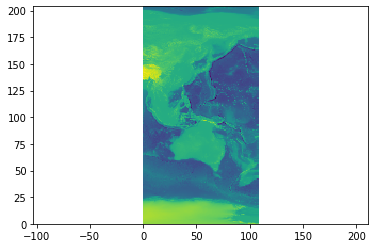

In [5]:
x0 = 90
x1 = 180
i0 = int((x0+180)*60)
i1 = int((x1+180)*60)

plt.pcolormesh(z[j0:j1:50,i0:i1:50])
plt.axis('equal')

Second patch

(0.0, 175.0, 0.0, 204.0)

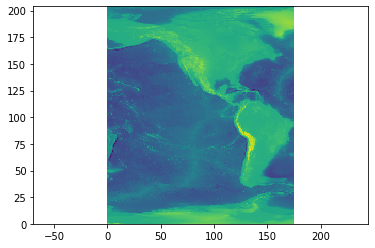

In [6]:
x2 = -34.17
i2 = int((x2+180)*60)

plt.pcolormesh(z[j0:j1:50,:i2:50])
plt.axis('equal')

Stitch them together but with another resolution

In [7]:
skip = 30
zfinal = -np.hstack([z[j0:j1:skip,i0:i1:skip], z[j0:j1:skip,:i2:skip]]).data

A small report

In [8]:
print('Mesh size:', zfinal.shape)
print(f"Range of longitude: {x0, x2+360}")
print(f"Range of latitude: {y0, y1}")

Mesh size: (340, 472)
Range of longitude: (90, 325.83)
Range of latitude: (-85, 85)


In [9]:
extent = {
    "lon": [x0, x2+360],
    "lat": [y0, y1]
}
extent

{'lon': [90, 325.83], 'lat': [-85, 85]}

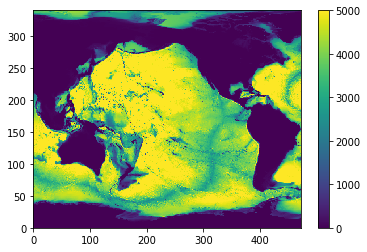

In [10]:
plt.pcolormesh(np.where(zfinal>=0, zfinal, 0), vmax=5000)
plt.colorbar()

Save it to be used by Nami

In [11]:
arr = np.hstack([zfinal.shape[0],zfinal.shape[1],zfinal.ravel()])
file = 'bathymetry{}min'.format(skip)
arr.astype('float64').tofile('bathymetry{}min'.format(skip))
print(file)

bathymetry30min


np.savetxt('bathymetry{}min'.format(skip), arr.data)

# Easywave

In [13]:
def writeGRD(z,name, xll, xur, yll, yur):
    ncols = z.shape[1]
    nrows = z.shape[0]
    f = open(name,'w')
    f.write('DSAA\n')
    print('DSAA\n')
    f.write('%i %i\n'%(ncols, nrows))
    print('%i %i\n'%(ncols, nrows))
    f.write('%.3f %.3f\n'%(xll,xur))
    print('%.3f %.3f\n'%(xll,xur))
    f.write('%.3f %.3f\n'%(yll,yur))
    print('%.3f %.3f\n'%(yll,yur))


    f.write('%.3f %.3f\n'%(z.min(),z.max()))

    s = [' '.join(['%.5f '%num for num in z[-i,:]]) for i in range(z.shape[0])]

    for ss in s:
        f.write('%s\n'%ss)
    f.close()

# writeGRD(np.flipud(z),'bathymetry{}mins.grd'.format(k))

In [14]:
y0 = -70
y1 = 70
j0 = int((y0+90)*60)
j1 = int((y1+90)*60)
x0 = 90
x1 = 180
i0 = int((x0+180)*60)
i1 = int((x1+180)*60)
x2 = 290-360
i2 = int((x2+180)*60)

In [22]:
skip = 10
zewave = np.hstack([z[j0:j1:skip,i0:i1:skip], z[j0:j1:skip,:i2:skip]])
print('Mesh size:', zewave.shape)

Mesh size: (840, 1200)


In [23]:
print(x0,x2+360)
print(y0,y1)

90 290
-70 70


In [24]:
zfinal.shape

(340, 472)

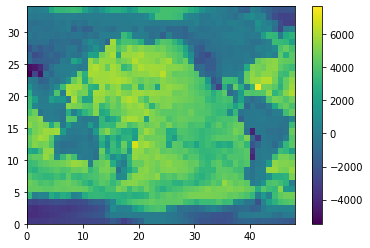

In [25]:
plt.pcolormesh(zfinal[::10,::10])
plt.colorbar()

In [26]:
writeGRD(np.flipud(zewave), 'bathymetryEasywave_{}min.grd'.format(skip), x0, x2+360, y0, y1)

DSAA

1200 840

90.000 290.000

-70.000 70.000



# Geoclaw

In [19]:
import clawpack.clawutil.data
import os

In [20]:
HOME = os.environ['HOME']

In [21]:
bathymetry_path = os.path.join(HOME, "work", "03_biobio2010", "geoclaw")

In [22]:
from clawpack.geoclaw import topotools

```
361 ncols
361 nrows
-120.0 xll
-60.0 yll
0.166666666667 cellsize
999999 nodata_value
-4207.0
```

In [29]:
topography = topotools.Topography()

topography.set_xyZ(
    np.linspace(extent["lon"][0], extent["lon"][1], zfinal.shape[1]),
    np.linspace(extent["lat"][0], extent["lat"][1], zfinal.shape[0]),
    -zfinal
)

In [30]:
topography.write(f"./topography{skip}min.tt2")

In [31]:
topo_read = topotools.Topography(
    f"./topography{skip}min.tt2", topo_type=2
)

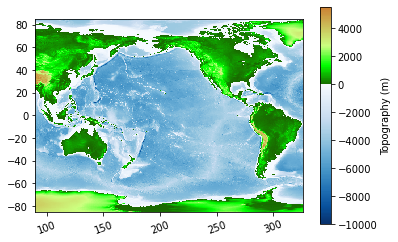

In [32]:
topo_read.plot()